In [24]:
import urllib2
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import datetime as dt
import os.path
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

In [25]:
def getMonthOfData(month):
	url = 'http://www.emi.ea.govt.nz/Reports/VisualTable'\
	'?reportName=VB5YEV&categoryName=Retail&reportGroupIndex=5'\
	'&reportDisplayContext=Gallery&eventMode=Sync&reportType=VisualTable'\
	'&param_DateFrom='+month.start_time.strftime('%d/%m/%Y')+\
	'&param_DateTo='+month.end_time.strftime('%d/%m/%Y')+\
	'&param_RegionType=REG_COUNCIL'\
	'&param_RetailEntity=Trader'\
	'&param_MarketSegment=All'\
	'&param_Show=All'

	#url2 = 'http://www.emi.ea.govt.nz/Reports/VisualTable?reportName=VB5YEV&categoryName=Retail&reportGroupIndex=5&reportDisplayContext=Gallery&eventMode=Sync&reportType=VisualTable&param_DateFrom=01/02/2016&param_DateTo=29/02/2016&param_RegionType=NWK_REPORTING_REGION_DIST&param_RetailEntity=Trader&param_MarketSegment=All&param_Show=All'
		
	page = urllib2.urlopen(url).read()
	soup = BeautifulSoup(page,"lxml")
	table=soup.find(id="tableReport_DXMainTable")

	#scrape retailer names, note first column='Total' and each column has three TDs: Gains, Losses, Net 
	retailers=[]
	i=0
	tr=table.find('tr',id="tableReport_DXHeadersRow0")
	for td in tr.find_all('td'):
		if (i!=1) and ((i-1)%3 ==0):	#we want i=4,7,10 etc but not i=1
			#print "%s: %s" % (j, td.text)
			retailers.append(td.text)
		i+=1
	#print "retailers: %s; %s" % (len(retailers), retailers)

	#scrape region names
	regions=[]
	for tr in table.find_all('tr',class_="dxgvDataRow"):
		regions.append(tr.find('td').text) #it's always the first td in the tr
	#print "regions: %s; %s" % (len(regions), regions)

	#scrape data cells, note it will be 3*toprow wide and leftcol tall
	#gains = np.zeros([len(regions),len(retailers)], dtype=int)
	gains = np.zeros([len(regions),len(retailers)], dtype=int)
	losses = np.zeros([len(regions),len(retailers)], dtype=int)
	net = np.zeros([len(regions),len(retailers)], dtype=int)
	#gains[:]=losses[:]=net[:]=np.NaN

	i=0
	for tr in table.find_all('tr',class_="dxgvDataRow"):
	#	print "tr %s has %s tds" % (i, len(tr.find_all('td')))
		j=k=0
		for td in tr.find_all('td'):
	#		print "i %s j %s k %s td %s" % (i,j,k, td.text)
			if not td.text:				#empty string, move on
				pass
			elif k == 0:				#k0=Auckland, k1=gains k2=losses, k3=net, k4=gains, etc
				pass
			elif k%3 == 1:
				gains[i,j]=int(td.text.replace(',',''))
				#print "i %s j %s k %s td %s " % (i,j,k,td.text)
				#print gains[i,]
			elif k%3 == 2:
				losses[i,j]=int(td.text.replace(',',''))
			elif k%3 == 0:
				net[i,j]=int(td.text.replace(',',''))
				j+=1
			k+=1

		i+=1

	gains=pd.DataFrame(gains,index=regions,columns=retailers)
	gains=gains.unstack().reset_index(name='gains')
	gains.rename(columns={'level_0': 'retailer', 'level_1':'region'}, inplace=True)

	losses=pd.DataFrame(losses,index=regions,columns=retailers)
	losses=losses.unstack().reset_index(name='losses')
	losses.rename(columns={'level_0': 'retailer', 'level_1':'region'}, inplace=True)

	net=pd.DataFrame(net,index=regions,columns=retailers)
	net=net.unstack().reset_index(name='net')
	net.rename(columns={'level_0': 'retailer', 'level_1':'region'}, inplace=True)

	df=pd.merge(gains,pd.merge(losses,net))
	df['month']=month #pd.Period(start.strftime('%Y-%m','M')
	print '%s has %s rows x %s columns' % (month, len(df), len(df.columns))
	return df;

In [26]:
if os.path.exists('df.pickle'):
	df = pickle.load(open('df.pickle'))
else:
	months = pd.period_range('2010-01','2016-02',freq='M')
	for m in months:
		if 'df' not in locals():
			df = getMonthOfData(m)
		else:
			df = pd.concat([df,getMonthOfData(m)])
		df.to_pickle('df.pickle')

In [31]:
plt.figure(); df['retailer'=='Total'].plot();

KeyError: False

AttributeError: 'FigureCanvasAgg' object has no attribute 'invalidate'

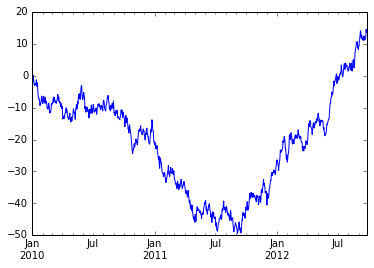

In [28]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2010', periods=1000))
ts = ts.cumsum()
ts.plot();

AttributeError: 'FigureCanvasAgg' object has no attribute 'invalidate'

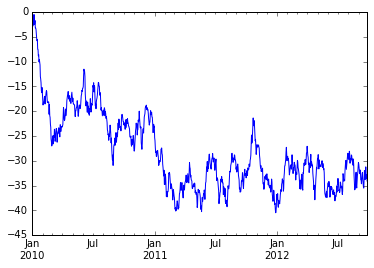

In [29]:
df2 = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))
df2 = df2.cumsum()
plt.figure()
df2.plot()